In [1]:
import os
import random
import sys

import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import utils as tl_utils
from transformer_lens import HookedTransformer
from collections import defaultdict
from tqdm.auto import tqdm
import einops

### Load Model and Data

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "meta-llama/Llama-2-7b-chat-hf"# "meta-llama/Meta-Llama-3-8B-Instruct" # "google/gemma-2-9b"
model_type = "llama2_7b" # "gemma-2"

model = HookedTransformer.from_pretrained(
    model_name_or_path,
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16,
)
n_layers = model.cfg.n_layers
tokenizer = model.tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [3]:
test_attacks = ["AutoPrompt", "FewShot", "GCG", "PAIR", "TAP"]

harmbench_behaviors = pd.read_csv("tasks/harmbench/data/harmbench_data/behavior_datasets/harmbench_behaviors_text_all.csv").set_index("BehaviorID")

for attack_name in test_attacks:
    # open tasks/harmbench/data/harmbench_concise/{attack_name}/llama2_7b/test_cases/test_cases.json
    test_cases = pd.read_json(f"tasks/harmbench/data/harmbench_concise/{attack_name}/{model_type}/test_cases/test_cases.json").T.rename({0: attack_name}, axis=1)
    test_cases.index.name = "BehaviorID"
    harmbench_behaviors = harmbench_behaviors.join(test_cases, on="BehaviorID")

harmbench_behaviors = harmbench_behaviors.query("FunctionalCategory == 'standard' or FunctionalCategory == 'contextual'").rename({"Behavior": "DirectRequest"}, axis=1)
print(harmbench_behaviors.shape)

# randomly harmbench_behaviors split 1/3-1/3-1/3 train-val-test
train_harmbench_behaviors = harmbench_behaviors.sample(frac=1/3, random_state=42)
val_harmbench_behaviors = harmbench_behaviors.drop(train_harmbench_behaviors.index).sample(frac=1/3, random_state=42)
test_harmbench_behaviors = harmbench_behaviors.drop(train_harmbench_behaviors.index).drop(val_harmbench_behaviors.index)

attack_names = ["DirectRequest"] + test_attacks

custom_clean_data = pd.read_csv("tasks/harmbench/data/clean_behaviors.csv")

(300, 10)


In [4]:
# load from Mechanistic-Anomaly-Detection/llama3-jailbreaks
benign_train_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks", split="benign_instructions_train")
benign_test_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks", split="benign_instructions_test")

harmful_train_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks", split="harmful_instructions_train")
harmful_test_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks", split="harmful_instructions_test")

# strip llama3 chat template
# 'prompt' column looks like: <|begin_of_text|><|start_header_id|>user<|end_header_id|> Can you tell me about some of the notable start-ups operating in Sao Paulo's tech scene?<|eot_id|><|start_header_id|>assistant<|end_header_id|>
def strip_template(text):
    stripped_text = text.split("<|eot_id|>")[0].split("<|end_header_id|>\n\n")[1]
    # if there is any punctuation at the end (., !, ?), remove it
    if stripped_text[-1] in ['.', '!']:
        stripped_text = stripped_text[:-1]
    return stripped_text


n_train_prompts = 2500
n_test_prompts = 750

benign_train_prompts = [strip_template(x) for x in benign_train_dataset["prompt"]][:n_train_prompts]
benign_test_prompts = [strip_template(x) for x in benign_test_dataset["prompt"]][:n_test_prompts]
harmful_train_prompts = [strip_template(x) for x in harmful_train_dataset["prompt"]][:n_train_prompts]
harmful_test_prompts = [strip_template(x) for x in harmful_test_dataset["prompt"]][:n_test_prompts]

In [5]:
def apply_chat_template(prompt_list):
    new_prompt_list = []
    for prompt in prompt_list:
        prompt = tokenizer.apply_chat_template([{"role": "system", "content": "You are a helpful AI Assistant!"}, {"role": "user", "content": prompt}], tokenize=False) + " "
        new_prompt_list.append(prompt)
    return new_prompt_list
def retrieve_acts(model, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None):
    if layer is None:
        caches = defaultdict(list)
    else:
        caches = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            prompt_toks = prompt_toks[:, -truncate_length:]
            attn_mask = attn_mask[:, -truncate_length:]

        _, cache = model.run_with_cache(
            prompt_toks,
            attention_mask=attn_mask,
            names_filter = (lambda name: f"hook_resid_post" in name) if layer is None else (f"blocks.{layer}.hook_resid_post")
        )
        if layer is None:
            for k, v in cache.items():
                key_layer = int(k.split(".")[1])
                if to_cpu:
                    caches[key_layer].append(v[:, -1, :].cpu())
                else:
                    caches[key_layer].append(v[:, -1, :])
        else:
            if to_cpu:
                caches.append(cache[f"blocks.{layer}.hook_resid_post"][:, -1, :].cpu())
            else:
                caches.append(cache[f"blocks.{layer}.hook_resid_post"][:, -1, :])
    if layer is None:
        for k, v in caches.items():
            caches[k] = torch.cat(v, dim=0)
    else:
        caches = torch.cat(caches, dim=0)
    return caches

In [6]:
# split into 2-1 train-test split
import pickle
load_caches = False
save_caches = True

if not load_caches:
    attack_batches = {"DirectRequest": 8, "AutoPrompt": 1, "FewShot": 1, "GCG": 1, "PAIR": 1, "TAP": 1}
    # harmbench_cache = {}
    clean_cache = {}    
    train_harmbench_cache = {}
    val_harmbench_cache = {}
    test_harmbench_cache = {}
    for attack_name in attack_names:
        train_harmbench_cache[attack_name] = retrieve_acts(model, apply_chat_template(train_harmbench_behaviors[attack_name].values.tolist()), batch_size=attack_batches[attack_name], to_cpu=True)
        val_harmbench_cache[attack_name] = retrieve_acts(model, apply_chat_template(val_harmbench_behaviors[attack_name].values.tolist()), batch_size=attack_batches[attack_name], to_cpu=True)
        test_harmbench_cache[attack_name] = retrieve_acts(model, apply_chat_template(test_harmbench_behaviors[attack_name].values.tolist()), batch_size=attack_batches[attack_name], to_cpu=True)

    clean_cache = retrieve_acts(model, apply_chat_template(custom_clean_data["goal"].values.tolist()), batch_size=16, to_cpu=True)

    benign_train_cache = retrieve_acts(model, apply_chat_template(benign_train_prompts), batch_size=2, to_cpu=True)
    benign_test_cache = retrieve_acts(model, apply_chat_template(benign_test_prompts), batch_size=2, to_cpu=True)
    harmful_train_cache = retrieve_acts(model, apply_chat_template(harmful_train_prompts), batch_size=2, to_cpu=True)
    harmful_test_cache = retrieve_acts(model, apply_chat_template(harmful_test_prompts), batch_size=2, to_cpu=True)

    if save_caches:
        with open("act_caches.pkl", "wb") as f:
            pickle.dump({"benign_train_cache": benign_train_cache, "benign_test_cache": benign_test_cache, "harmful_train_cache": harmful_train_cache, "harmful_test_cache": harmful_test_cache, "clean_cache": clean_cache, "train_harmbench_cache": train_harmbench_cache, "val_harmbench_cache": val_harmbench_cache, "test_harmbench_cache": test_harmbench_cache}, f)

else:
    with open("act_caches.pkl", "rb") as f:
        act_caches = pickle.load(f)
    benign_train_cache = act_caches["benign_train_cache"]
    benign_test_cache = act_caches["benign_test_cache"]
    harmful_train_cache = act_caches["harmful_train_cache"]
    harmful_test_cache = act_caches["harmful_test_cache"]
    clean_cache = act_caches["clean_cache"]
    train_harmbench_cache = act_caches["train_harmbench_cache"]
    val_harmbench_cache = act_caches["val_harmbench_cache"]
    test_harmbench_cache = act_caches["test_harmbench_cache"]

  0%|          | 0/13 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

## Non-mechanistic Anomaly Detection

### Assuming Gaussian

In [7]:
# fit gaussian to all data together
# this probably shouldn't work

### Assuming Bimodal

In [8]:
# # anomaly detection using resid stream at a particular layer, very high-dimensional
# layer = 12

# X = torch.cat([benign_train_cache[layer].float(), harmful_train_cache[layer].float()], dim=0)
# y = torch.cat([torch.zeros(benign_train_cache[layer].shape[0]), torch.ones(harmful_train_cache[layer].shape[0])], dim=0)
# # shuffle
# perm = torch.randperm(X.shape[0])
# X = X[perm]
# y = y[perm]

# import numpy as np
# from sklearn.mixture import GaussianMixture
# from sklearn.preprocessing import StandardScaler

# # Assuming you have your data in `X` and labels in `y`
# # X is of shape (6000, 4000) and y is of shape (6000,)

# # Step 1: Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Step 2: Split the data based on labels
# X_label_0 = X_scaled[y == 0]
# X_label_1 = X_scaled[y == 1]

# # Step 3: Fit separate Gaussians to each subset
# gmm_0 = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
# gmm_1 = GaussianMixture(n_components=1, covariance_type='full', random_state=42)

# print("Fitting GMMs")
# gmm_0.fit(X_label_0)
# gmm_1.fit(X_label_1)

# # Step 4: Initialize a GMM with 2 components using the fitted means and covariances
# means_init = np.vstack([gmm_0.means_, gmm_1.means_])
# covariances_init = np.array([gmm_0.covariances_[0], gmm_1.covariances_[0]])

# print("Done fitting GMMs, now fitting constrained GMM")
# gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, means_init=means_init)

# # Manually setting covariances requires more work
# gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances_init))

# # Step 5: Fit the GMM to the entire dataset
# gmm.fit(X_scaled)

# # Step 6: Predict the component (0 or 1) for each point
# gmm_labels = gmm.predict(X_scaled)

# # Step 7: Evaluate the model
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y, gmm_labels)
# print(f"Constrained GMM Accuracy: {accuracy:.2f}")


## Mechanistic Anomaly Detection using Probes

In [7]:
# read 3000 random prompts from harmful_train_prompts, 500 random benign prompts
# harmful_strings = pd.Series(harmful_train_prompts).sample(n=500, random_state=42).tolist()
# benign_strings = pd.Series(benign_train_prompts).sample(n=500, random_state=42).tolist()

# no LAT formatting required, just do standard PCA
# sample_harmful_cache = retrieve_acts(model, apply_chat_template(harmful_strings), batch_size=8, to_cpu=True)
# sample_benign_cache = retrieve_acts(model, apply_chat_template(benign_strings), batch_size=4, to_cpu=True)


sample_harmful_cache = harmful_train_cache
sample_benign_cache = benign_train_cache

### RepE
Using the "jailbreak" vector to read jailbreaks, from section 6.2. I don't think this will work since this might also fire on benign prompts.

In [8]:
# layer = 12
# PCA

from sklearn.decomposition import PCA

def get_reading_vector(layer, verbose=False, use_pca=True):
    harmful_layer_cache = sample_harmful_cache[layer].float().numpy()
    benign_layer_cache = sample_benign_cache[layer].float().numpy()

    if use_pca:
        pca = PCA(n_components=1) # just get the first principal component

        diff_cache = (harmful_layer_cache - benign_layer_cache) # shape (64, 4096)
        # invert every other row
        invert_indices = np.arange(0, len(harmful_layer_cache), 1) % 2 == 1
        diff_cache[invert_indices] = -diff_cache[invert_indices]

        pca.fit(diff_cache)
        reading_vector = pca.components_.squeeze()
    else:
        # diff in means
        reading_vector = (harmful_layer_cache.mean(axis=0) - benign_layer_cache.mean(axis=0)).squeeze()
    # assign a direction, should be 1 on harmful, -1 on benign

    if np.sign(einops.einsum(reading_vector, harmful_layer_cache, "d, b d -> b")).mean() < 0:
        reading_vector = -reading_vector

    if verbose:
        print(f"Sign on harmful is {np.sign(einops.einsum(reading_vector, harmful_layer_cache, 'd, b d -> b')).mean()}, sign on benign is {np.sign(einops.einsum(reading_vector, benign_layer_cache, 'd, b d -> b')).mean()}")
    return reading_vector

reading_vector = get_reading_vector(layer=12, verbose=True, use_pca=False)

Sign on harmful is 1.0, sign on benign is -0.8040000200271606


AUROC for DirectRequest: 0.9996
AUROC for AutoPrompt: 0.8948
AUROC for FewShot: 0.9244
AUROC for GCG: 0.8650
AUROC for PAIR: 0.7655
AUROC for TAP: 0.7683

AUROC for all attacks combined: 0.8696


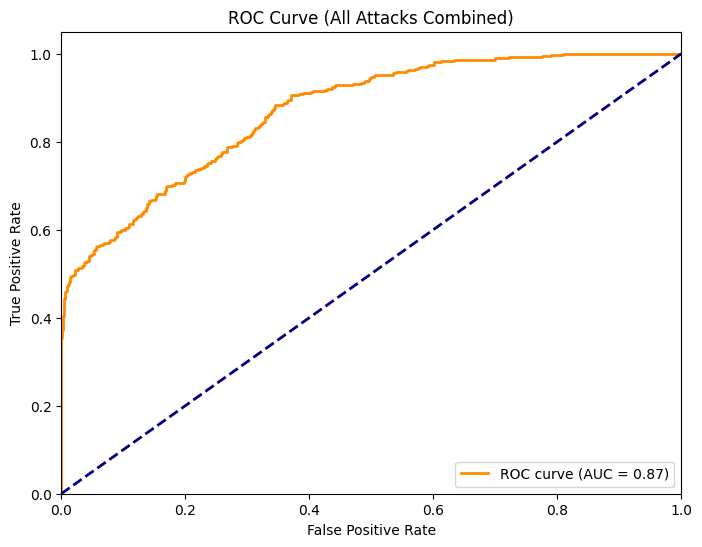

In [9]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_aurocs(layer, reading_vector, plot=False, on_test=False):

    aurocs = {}
    benign_data = benign_test_cache[layer].float().numpy()

    def calculate_auroc(harmful_data, benign_data, reading_vector):
        labels = np.concatenate([np.ones(harmful_data.shape[0]), np.zeros(benign_data.shape[0])])
        all_data = np.concatenate([harmful_data, benign_data])
        scores = einops.einsum(reading_vector, all_data, "d, b d -> b")
        fpr, tpr, _ = roc_curve(labels, scores)
        return auc(fpr, tpr)

    # Calculate AUROC for each attack individually
    for attack_name in attack_names:
        if on_test:
            attack_data = test_harmbench_cache[attack_name][layer].float().numpy()
        else:
            attack_data = val_harmbench_cache[attack_name][layer].float().numpy()
        attack_auroc = calculate_auroc(attack_data, benign_data, reading_vector)
        if plot:
            print(f"AUROC for {attack_name}: {attack_auroc:.4f}")
        aurocs[attack_name] = attack_auroc

    # Calculate AUROC for all attacks combined
    if on_test:
        all_harmful_data = np.concatenate([test_harmbench_cache[attack][layer].float().numpy() for attack in attack_names])
    else:
        all_harmful_data = np.concatenate([val_harmbench_cache[attack][layer].float().numpy() for attack in attack_names])
    combined_auroc = calculate_auroc(all_harmful_data, benign_data, reading_vector)
    aurocs["Aggregated"] = combined_auroc
    if plot:
        print(f"\nAUROC for all attacks combined: {combined_auroc:.4f}")

    # Plot ROC curve for all attacks combined
    labels = np.concatenate([np.ones(all_harmful_data.shape[0]), np.zeros(benign_data.shape[0])])
    all_data = np.concatenate([all_harmful_data, benign_data])
    scores = einops.einsum(reading_vector, all_data, "d, b d -> b")
    fpr, tpr, thresholds = roc_curve(labels, scores)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {combined_auroc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (All Attacks Combined)')
        plt.legend(loc="lower right")
        plt.show()
    return aurocs

aurocs = get_aurocs(layer=12, reading_vector=reading_vector, plot=True)

  0%|          | 0/32 [00:00<?, ?it/s]

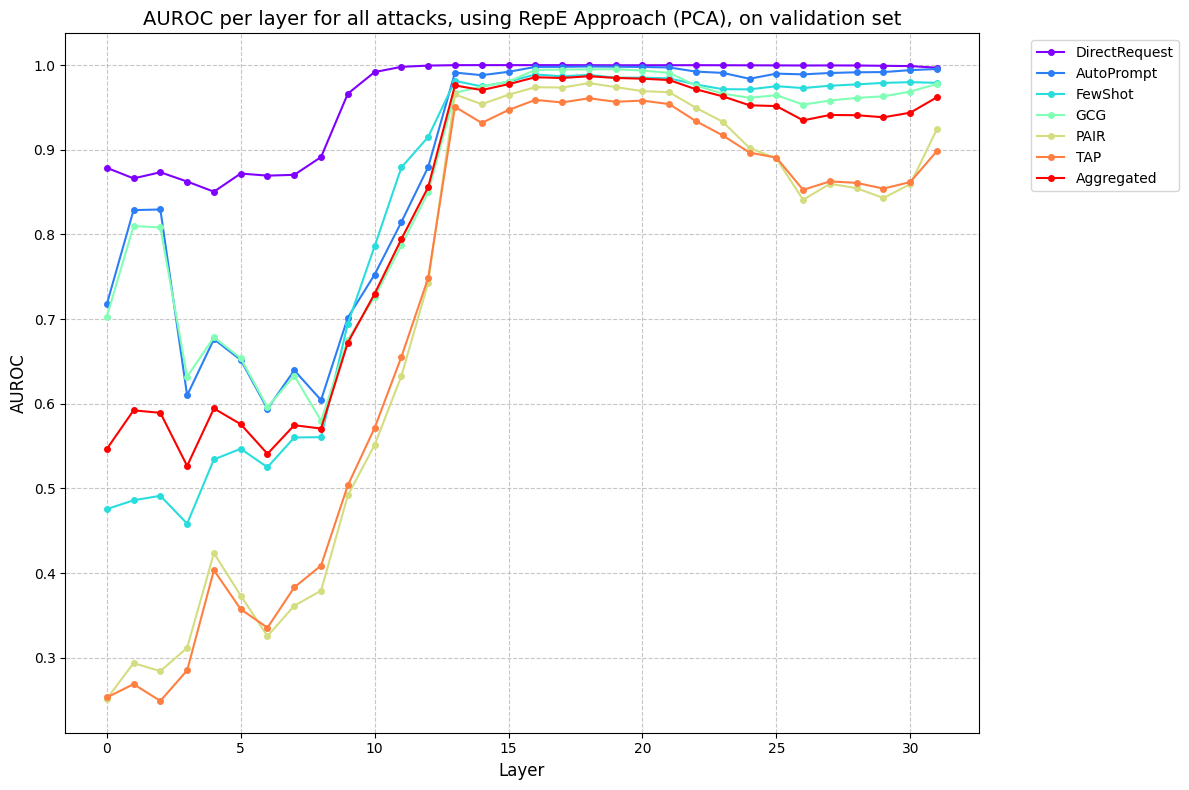

In [10]:
# plot AUROC per layer
on_test = False
repe_layer_aurocs = defaultdict(list)
for layer in tqdm(range(model.cfg.n_layers)):
    reading_vector = get_reading_vector(layer=layer, verbose=False)
    aurocs = get_aurocs(layer=layer, reading_vector=reading_vector, plot=False)
    for attack_name, auroc in aurocs.items():
        repe_layer_aurocs[attack_name].append(auroc)

# Create a single plot for all attacks
plt.figure(figsize=(12, 8))

# Define a color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(repe_layer_aurocs)))

for (attack_name, aurocs), color in zip(repe_layer_aurocs.items(), colors):
    plt.plot(range(model.cfg.n_layers), aurocs, '-o', label=attack_name, color=color, markersize=4)

plt.xlabel("Layer", fontsize=12)
plt.ylabel("AUROC", fontsize=12)
plt.title(f"AUROC per layer for all attacks, using RepE Approach (PCA), on test set" if on_test else "AUROC per layer for all attacks, using RepE Approach (PCA), on validation set", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

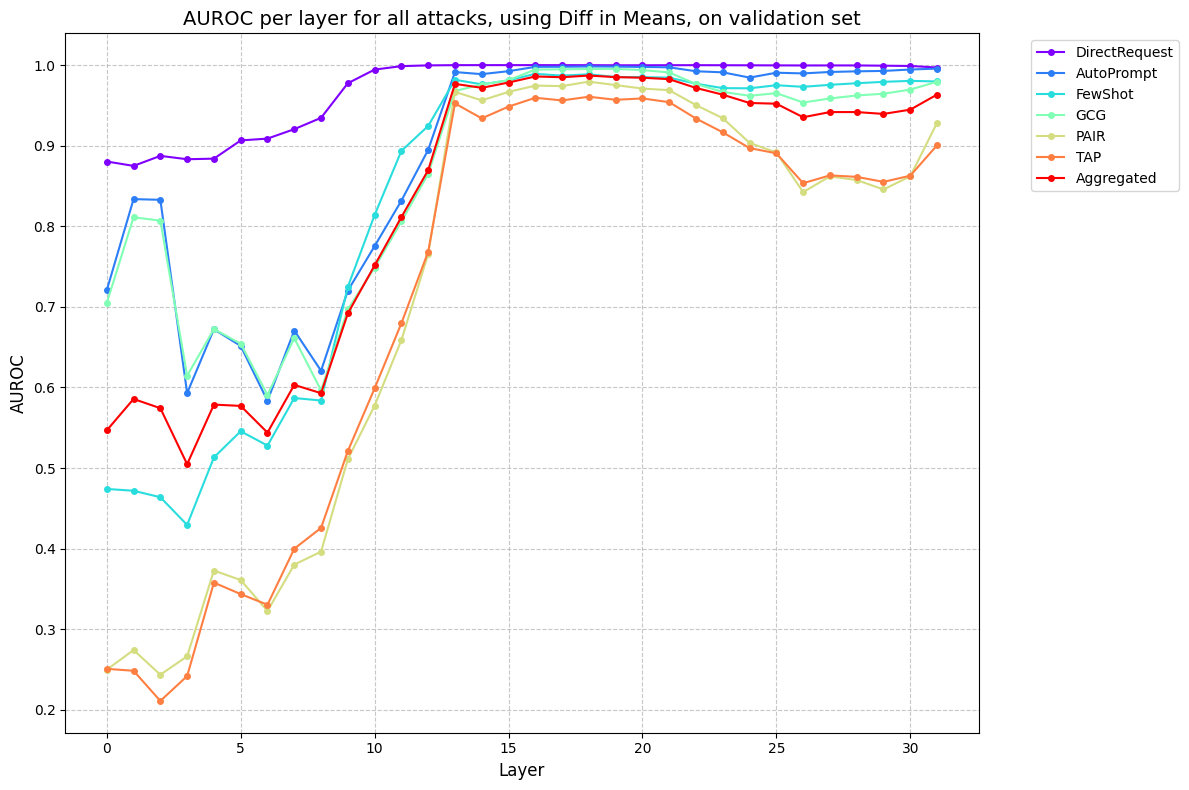

In [11]:
# plot AUROC per layer
repe_layer_aurocs = defaultdict(list)
for layer in tqdm(range(model.cfg.n_layers)):
    reading_vector = get_reading_vector(layer=layer, verbose=False, use_pca=False)
    aurocs = get_aurocs(layer=layer, reading_vector=reading_vector, plot=False)
    for attack_name, auroc in aurocs.items():
        repe_layer_aurocs[attack_name].append(auroc)

# Create a single plot for all attacks
plt.figure(figsize=(12, 8))

# Define a color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(repe_layer_aurocs)))

for (attack_name, aurocs), color in zip(repe_layer_aurocs.items(), colors):
    plt.plot(range(model.cfg.n_layers), aurocs, '-o', label=attack_name, color=color, markersize=4)

plt.xlabel("Layer", fontsize=12)
plt.ylabel("AUROC", fontsize=12)
plt.title("AUROC per layer for all attacks, using Diff in Means, on test set" if on_test else "AUROC per layer for all attacks, using Diff in Means, on validation set", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

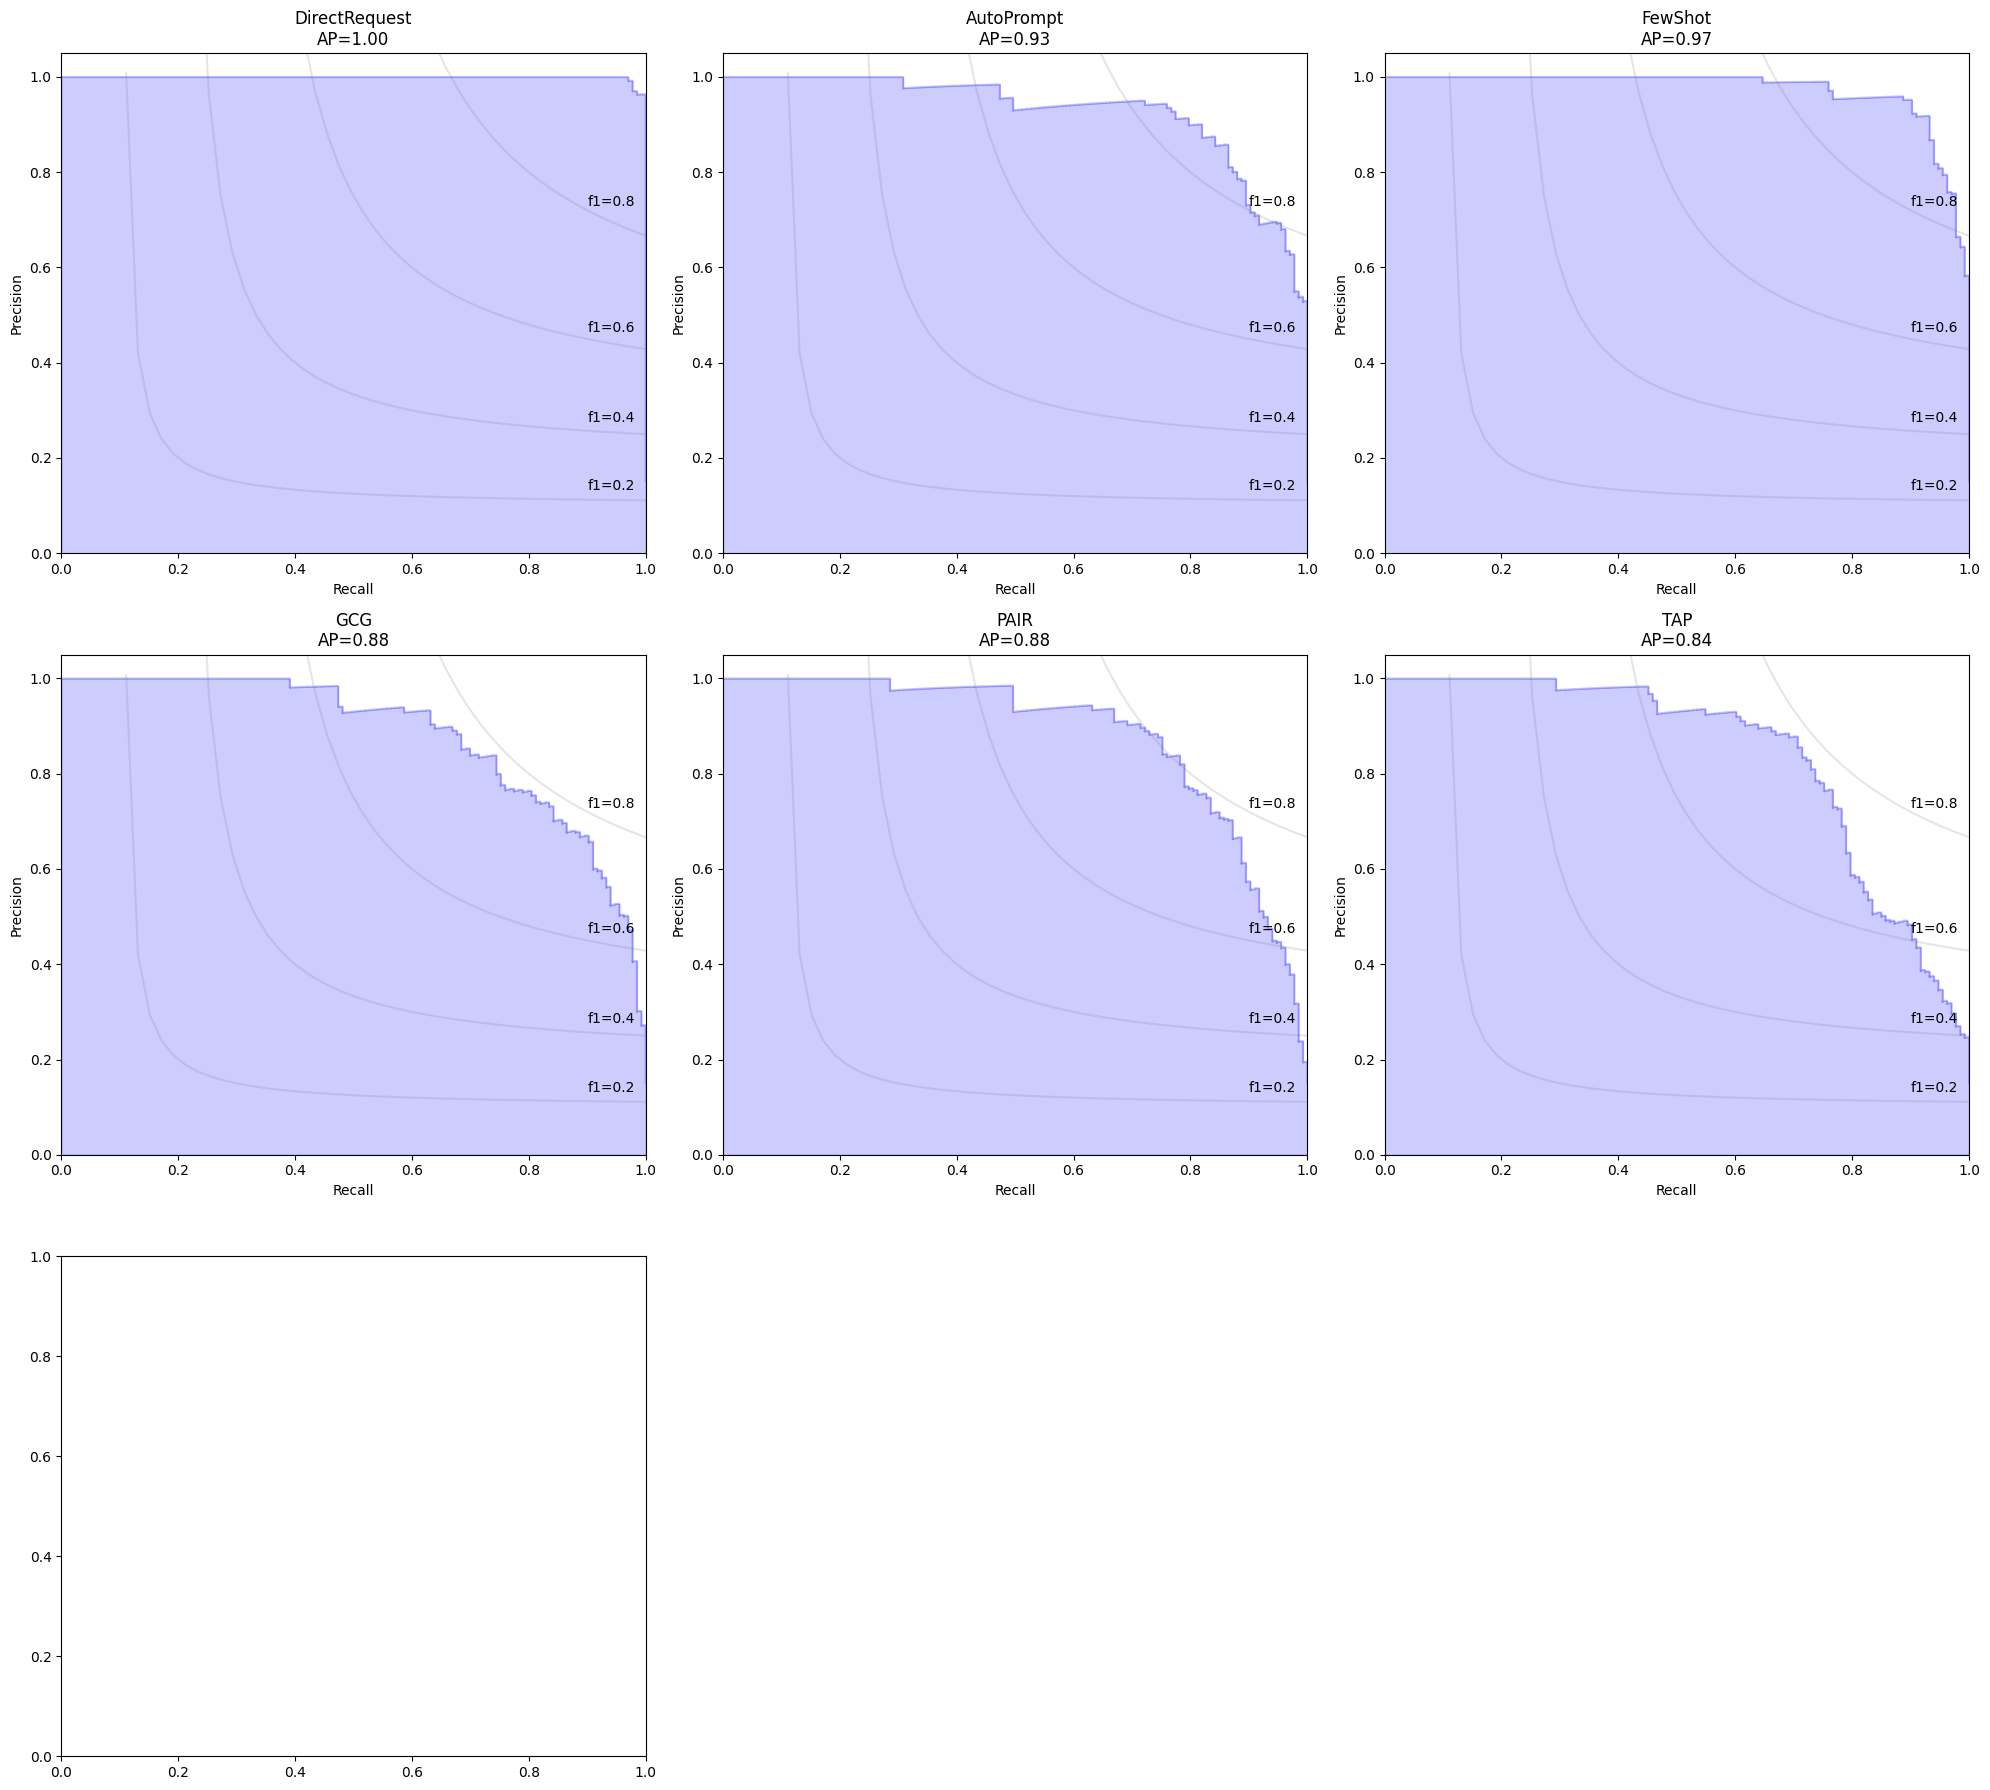

Threshold values for aggregated data:
Threshold: -89.0076, Precision: 0.5155, Recall: 1.0000
Threshold: -65.6392, Precision: 0.5725, Recall: 1.0000
Threshold: -57.4652, Precision: 0.6427, Recall: 0.9987
Threshold: -49.8581, Precision: 0.7274, Recall: 0.9900
Threshold: -41.3395, Precision: 0.8326, Recall: 0.9724
Threshold: -29.2245, Precision: 0.9293, Recall: 0.9048
Threshold: -12.3908, Precision: 0.9856, Recall: 0.7694
Threshold: 13.4390, Precision: 0.9979, Recall: 0.5865
Threshold: 77.1519, Precision: 1.0000, Recall: 0.3947
Threshold: 234.0664, Precision: 1.0000, Recall: 0.1980
Threshold: 375.1766, Precision: 1.0000, Recall: 0.0050


In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# Get the reading vector for layer 13
layer = 13
reading_vector = get_reading_vector(layer=layer, verbose=False, use_pca=False)

# Prepare the benign data
benign_data = benign_test_cache[layer].float().numpy()

# Calculate number of rows and columns for subplots
n_plots = len(attack_names) + 1  # +1 for aggregated plot
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
axes = axes.flatten()

def plot_pr_curve(ax, precision, recall, average_precision, title):
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(f'{title}\nAP={average_precision:0.2f}')
    
    # Add iso-f1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

# Plot for each attack
for i, attack_name in enumerate(attack_names):
    attack_data = test_harmbench_cache[attack_name][layer].float().numpy()
    all_data = np.concatenate([attack_data, benign_data])
    labels = np.concatenate([np.ones(attack_data.shape[0]), np.zeros(benign_data.shape[0])])
    scores = einops.einsum(reading_vector, all_data, "d, b d -> b")
    
    precision, recall, _ = precision_recall_curve(labels, scores)
    average_precision = average_precision_score(labels, scores)
    
    plot_pr_curve(axes[i], precision, recall, average_precision, attack_name)

# Plot for aggregated data
all_harmful_data = np.concatenate([test_harmbench_cache[attack][layer].float().numpy() for attack in attack_names])
all_data = np.concatenate([all_harmful_data, benign_data])
labels = np.concatenate([np.ones(all_harmful_data.shape[0]), np.zeros(benign_data.shape[0])])
scores = einops.einsum(reading_vector, all_data, "d, b d -> b")

precision, recall, thresholds = precision_recall_curve(labels, scores)
average_precision = average_precision_score(labels, scores)

plot_pr_curve(axes[-1], precision, recall, average_precision, 'Aggregated')

# Remove any unused subplots
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Print some threshold values for the aggregated data
print("Threshold values for aggregated data:")
for i in range(0, len(thresholds), len(thresholds) // 10):
    print(f"Threshold: {thresholds[i]:.4f}, Precision: {precision[i]:.4f}, Recall: {recall[i+1]:.4f}")

### Circuit Breaker/Rowan approach

In [15]:
# train dedicated linear and MLP probes
# could calculate AUROC again by varying bias term (only second bias term in the MLP), or just calculate precision and recall

sample_harmful_cache = harmful_train_cache
sample_benign_cache = benign_train_cache

layer = 12

all_data = np.concatenate([sample_harmful_cache[layer].float().numpy(), sample_benign_cache[layer].float().numpy()])
labels = np.concatenate([np.ones(sample_harmful_cache[layer].shape[0]), np.zeros(sample_benign_cache[layer].shape[0])])
# shuffle
shuffle_indices = np.arange(len(all_data))
np.random.shuffle(shuffle_indices)
all_data = all_data[shuffle_indices]
labels = labels[shuffle_indices]

# train linear probe
from sklearn.linear_model import LogisticRegression
linear_probe = LogisticRegression(max_iter=1000)
linear_probe.fit(all_data, labels)

# train 2 layer MLP probe, hidden layer sizes 32, 32
from sklearn.neural_network import MLPClassifier
print("Training MLP probe")
mlp_probe = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=100000)
mlp_probe.fit(all_data, labels)

# evaluate recall and precision

### QLM

In [13]:
# train probes on every layer

# bimodal distribution


## Mechanistic Analysis
Find weird attention patterns from andy/aaquib work